In [1]:
#### General packages
import pickle
import os
import os.path as op
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy
import healpy as hp
import emcee
import yaml
from multiprocessing import Pool
from getdist import plots, MCSamples
import getdist
import time

sys.path.append('/pbs/home/t/tlaclave/sps/Pipeline')

#### QUBIC packages
import qubic
from qubic import NamasterLib as nam
from qubicpack.utilities import Qubic_DataDir
from qubic import QubicSkySim as qss
from pysimulators import FitsArray
from qubic import fibtools as ft
from qubic import camb_interface as qc
from qubic import SpectroImLib as si
import mapmaking.systematics as acq
from qubic import mcmc
from qubic import AnalysisMC as amc
from qubic.beams import BeamGaussian
import fgb.component_model as c
import fgb.mixing_matrix as mm
from pysimulators.interfaces.healpy import HealpixConvolutionGaussianOperator
from pipeline_notebook import *
from pyoperators import *

#### Nested Sampling packages
import dynesty
from dynesty import plotting as dyplot
from dynesty import NestedSampler
from dynesty import DynamicNestedSampler
from dynesty import utils as dyfunc

%matplotlib inline

Step-by-step explanations of the notebook

1) Frequency Map-Making

All the FMM codes are stored on : https://github.com/mathias77515/Pipeline/tree/Tom-dev
You have to use the yaml file 'params.yml' (open outside this notebook) in order to configure the FMM parameters. After that, the line 'PipelineEnd2End(comm).main()' will start a FMM simulation and store the results (maps, parameters, ...) into a pickle file at the 'path_out' (in params.yaml) location. You can import this file(s) as a Python dictionnary with pickle.load(open(your_path, 'rb')). I have write examples in following cells, even to import many simulations easily. This pickle file(s) will be used to compute the power spectra.

2) Power Spectra

To compute power spectra, you will use the class Spectra. It will work with the dictionnary 'param_spectrum', where you will have to write the path for your noise and sky (cmb + dust) realisations. I think that it's more conveniant to compute the power spectrum for one noise realisation and one sky realisation simultaneously, because it allows Spectra to return a pickle file with these two spectra. It's just a technical choice but it's very easy to change it if you want in the __init__ function. You will have to change the class Data in order to take into account this kind of modification.
Spectra will compute auto-spectrum for each reconstructed frequency sub-bands and cross-spectrum between all the reconstructed frequency sub-bands, and store them in an array with dimension = Nrec x Nrec (for both noise and sky realisation), with the diagonal fills with auto-spectra and the triangle parts fill with cross-spectra. The function 'find_data' and 'save' are used to select the pair of realisations (noise and sky) on which the power spectra will be computed. The result will be stored in a pickle file at the 'path_out' location.

3) Fitting

To fit the chosen parameter(s) with your spectra, you will have to use the 'param_sampling' dictionnary. With this dictionnary, you will give the path where your power spectra are store and the simulations parameters (just for plots names if I'm not mistaken...). You will also choose the fitting method (Nested Sampling or MCMC) anf their parameters. After that, the code will correct the power spectra of the sky using the noise power spectra and use them to achieve the fit. Some useful plots will be shown at the end to understand if the fit was successful and the triangle plot with the estimation of your parameters.

In [188]:
# MPI object
comm = MPI.COMM_WORLD

In [189]:
##############################
#### Frequency Map-Making ####
##############################

In [119]:
# Command to start FMM, according to the parameters in "params.yml"
# This will create a pickle file at the location setted by 'path_out' in this yaml file

### Please note that you don't need to simulate maps every time you launch the notebook, you can just use a loop to generate N maps and use the same ones each time

#PipelineEnd2End(comm).main()

### You also need to do a simulation for CMB & Dust = False, in order to have a noise realisation. It is mandatory for the fitting part

In [5]:
# Import the FMM results
FMM_sky = pickle.load(open(your_path_for_sky_simulation, 'rb'))
FMM_noise = pickle.load(open(your_path_for_noise_simulation, 'rb'))

# Import the maps and the parameters used to simulate them from pickle files generated with pipeline.py
map_sky = FMM_sky['maps']
simulation_parameters = FMM_sky['maps']
map_noise = FMM_noise['maps']

NameError: name 'your_path_for_sky_simulation' is not defined

In [ ]:
# I advise to compute many maps using pipeline.py on a computing cluster
# you can import this by using the commands :
your_path_sky, your_path_noise = '', ''
sky_names = os.listdir(your_path_sky)
noise_names = os.listdir(your_path_noise)
map_sky, map_noise = [], []
for i in range(len(your_simulations_names)):
    pickle_sky = pickle.load(open(your_path_sky + '/' + sky_names[i], 'rb'))
    pickle_noise = pickle.load(open(your_path_noise + '/' + noise_names[i], 'rb'))
    map_sky.append(pickle_sky['maps'])
    map_noise.append(pickle_noise['maps'])
    
simulation_parameters = pickle_sky['parameters']

In [ ]:
#######################
#### Power Spectra ####
#######################

In [120]:
# We define a dictionnary in order to give the usefull parameters to the Spectra Class
param_spectrum = {'data': 
                  # Path where the spectra will be stored
                  {'path_out': '/pbs/home/t/tlaclave/sps/Pipeline/spectra/spectra_comparison_pixwin_test/', 
                   # Path where the pickle files of the noise realisations are stored
                   'path_noise': '/pbs/home/t/tlaclave/sps/Pipeline/data_comparison/DB_Nrec=2_Noise', 
                   # Path where the pickle files of the sky realisations are stored
                   'path_sky': '/pbs/home/t/tlaclave/sps/Pipeline/data_comparison/DB_Nrec=2_Sky'},
                  'simu': 
                  # Parameters of the sky or noise realisations
                  {'nrec': 2, 
                   'qubic_config': 'DB'}, 
                  'Spectrum': 
                  # Namaster parameters
                  {'lmin': 40, 
                   'dl': 30, 
                   'nbins': 16}
                 }

In [121]:
class Spectra:
    '''
    Class to compute the different spectra for our realisations
    '''

    def __init__(self, iteration, param_spectrum):

        self.iter = iteration
        self.param_spectrum = param_spectrum
        self.path_sky = self.param_spectrum['data']['path_sky']
        self.path_noise = self.param_spectrum['data']['path_noise']
        self.pkl_sky = self.find_data(self.path_sky)
        self.pkl_noise = self.find_data(self.path_noise)
        self.sky_maps = self.pkl_sky['maps']
        self.noise_maps = self.pkl_noise['maps']
        self.nrec = self.param_spectrum['simu']['nrec']
        self.nsub = self.pkl_sky['parameters']['QUBIC']['nsub']
        self.nside = self.pkl_sky['parameters']['Sky']['nside']
        self.fsub = int(self.nsub / self.nrec)
        self.comm = MPI.COMM_WORLD
        self.size = self.comm.Get_size()
        self.my_dict, _ = self.get_dict()

        self.ell, self.namaster = NamasterEll(self.iter, self.param_spectrum).ell()
        _, allnus150, _, _, _, _ = qubic.compute_freq(150, Nfreq=int(self.nsub/2)-1, relative_bandwidth=0.25)
        _, allnus220, _, _, _, _ = qubic.compute_freq(220, Nfreq=int(self.nsub/2)-1, relative_bandwidth=0.25)
        self.allnus = np.array(list(allnus150) + list(allnus220))
        self.allfwhm = self.get_allfwhm()
        print('allnus', self.allnus)
        print('allfwhm', self.allfwhm)

    def find_data(self, path):
        '''
        Function to extract the pickle file of one realisation associated to the path and the iteration number given.

        Argument :
            - path (str) : path where the pkl files are located

        Return :
            - pkl file dictionary (dict)
        '''

        data_names = os.listdir(path)
        one_realisation = pickle.load(open(path + '/' + data_names[self.iter], 'rb'))

        return one_realisation

    def get_dict(self):
        """
        Method to modify the qubic dictionary.
        """

        nu_ave, delta_nu_over_nu = self.get_ultrawideband_config()
        params = self.pkl_sky['parameters']

        args = {'npointings':params['QUBIC']['npointings'], 
                'nf_recon':params['QUBIC']['nrec'], 
                'nf_sub':params['QUBIC']['nsub'], 
                'nside':params['Sky']['nside'], 
                'MultiBand':True, 
                'period':1, 
                'RA_center':params['QUBIC']['RA_center'], 
                'DEC_center':params['QUBIC']['DEC_center'],
                'filter_nu':nu_ave*1e9, 
                'noiseless':False, 
                'comm':self.comm, 
                'dtheta':params['QUBIC']['dtheta'],
                'nprocs_sampling':1, 
                'nprocs_instrument':self.size,
                'photon_noise':True, 
                'nhwp_angles':params['QUBIC']['nhwp_angles'], 
                'effective_duration':3, 
                'filter_relative_bandwidth':delta_nu_over_nu, 
                'type_instrument':'wide', 
                'TemperatureAtmosphere150':None, 
                'TemperatureAtmosphere220':None,
                'EmissivityAtmosphere150':None, 
                'EmissivityAtmosphere220':None, 
                'detector_nep':float(params['QUBIC']['detector_nep']), 
                'synthbeam_kmax':params['QUBIC']['synthbeam_kmax']}

        args_mono = args.copy()
        args_mono['nf_recon'] = 1
        args_mono['nf_sub'] = 1

        ### Get the default dictionary
        dictfilename = 'dicts/pipeline_demo.dict'
        d = qubic.qubicdict.qubicDict()
        d.read_from_file(dictfilename)
        dmono = d.copy()

        for i in args.keys():
            d[str(i)] = args[i]
            dmono[str(i)] = args_mono[i]

        return d, dmono

    def get_ultrawideband_config(self):
        """
        Method that pre-compute UWB configuration.
        """

        nu_up = 247.5
        nu_down = 131.25
        nu_ave = np.mean(np.array([nu_up, nu_down]))
        delta = nu_up - nu_ave
        return nu_ave, 2*delta/nu_ave
    
    def synthbeam(self, synthbeam_peak150_fwhm, dtype=np.float32):
        sb = SyntheticBeam()
        sb.dtype = np.dtype(dtype)
        nripples = self.my_dict['nripples']
        synthbeam_peak150_fwhm = np.radians(self.my_dict['synthbeam_peak150_fwhm'])
        if not nripples:
            sb.peak150 = BeamGaussian(synthbeam_peak150_fwhm)
        else:
            sb.peak150 = BeamGaussianRippled(synthbeam_peak150_fwhm,
                                             nripples=nripples)
        return sb
    
    def get_allfwhm(self):
        '''
        Function to compute the fwhm for all sub bands.

        Return :
            - allfwhm (list [nrec * nsub])
        '''

        synthbeam_peak150_fwhm = np.radians(self.my_dict['synthbeam_peak150_fwhm'])
        synthbeam = self.synthbeam(synthbeam_peak150_fwhm, dtype=np.float32)
        if self.pkl_sky['parameters']['QUBIC']['convolution'] is True:
            allfwhm = synthbeam.peak150.fwhm * (150 / self.allnus)
        else:
            allfwhm = np.zeros(len(self.allnus))

        return allfwhm

    def compute_auto_spectrum(self, map, fwhm):
        '''
        Function to compute the auto-spectrum of a given map

        Argument : 
            - map(array) [nrec/ncomp, npix, nstokes] : map to compute the auto-spectrum
            - allfwhm(float) : in radian
        Return : 
            - (list) [len(ell)] : BB auto-spectrum
        '''

        DlBB = self.namaster.get_spectra(map=map.T, map2=None, beam_correction = np.rad2deg(fwhm))[1][:, 2]
        return DlBB

    def compute_cross_spectrum(self, map1, fwhm1, map2, fwhm2):
        '''
        Function to compute cross-spectrum, taking into account the different resolution of each sub-bands

        Arguments :
            - map1 & map2 (array [nrec/ncomp, npix, nstokes]) : the two maps needed to compute the cross spectrum
            - fwhm1 & fwhm2 (float) : the respective fwhm for map1 & map2 in radian

        Return : 
            - (list) [len(ell)] : BB cross-spectrum
        '''

        # Put the map with the highest resolution at the worst one before doing the cross spectrum
        # Important because the two maps had to be at the same resolution and you can't increase the resolution
        if fwhm1<fwhm2 :
            C = HealpixConvolutionGaussianOperator(fwhm=np.sqrt(fwhm2**2 - fwhm1**2))
            convoluted_map = C*map1
            return self.namaster.get_spectra(map=convoluted_map.T, map2=map2.T, beam_correction = np.rad2deg(fwhm2))[1][:, 2]
        else:
            C = HealpixConvolutionGaussianOperator(fwhm=np.sqrt(fwhm1**2 - fwhm2**2))
            convoluted_map = C*map2
            return self.namaster.get_spectra(map=map1.T, map2=convoluted_map.T, beam_correction = np.rad2deg(fwhm1))[1][:, 2]

    def compute_array_power_spectra(self, maps):
        ''' 
        Function to fill an array with all the power spectra computed

        Argument :
            - maps (array [nreal, nrec/ncomp, npix, nstokes]) : all your realisation maps

        Return :
            - power_spectra_array (array [nrec/ncomp, nrec/ncomp]) : element [i, i] is the auto-spectrum for the reconstructed sub-bands i 
                                                                     element [i, j] is the cross-spectrum between the reconstructed sub-band i & j
        '''

        idx_lenght = self.nrec
        power_spectra_array = np.zeros((idx_lenght, idx_lenght, len(self.ell)))

        for i in range(idx_lenght):
            for j in range(idx_lenght):
                if i==j :
                    # Compute the auto-spectrum
                    power_spectra_array[i,j] = self.compute_auto_spectrum(maps[i], self.allfwhm[(i+1)*self.fsub - 1])
                else:
                    # Compute the cross-spectrum
                    power_spectra_array[i,j] = self.compute_cross_spectrum(maps[i], self.allfwhm[(i+1)*self.fsub - 1],maps[j], self.allfwhm[(j+1)*self.fsub - 1])
        return power_spectra_array

    def compute_power_spectra(self):
        '''
        Function to compute the power spectra array for the sky and for the noise realisations

        Return :
            - sky power spectra array (array [nrec/ncomp, nrec/ncomp])
            - noise power spectra array (array [nrec/ncomp, nrec/ncomp])
        '''

        sky_power_spectra = self.compute_array_power_spectra(self.sky_maps)
        noise_power_spectra = self.compute_array_power_spectra(self.noise_maps)
        return sky_power_spectra, noise_power_spectra

class SyntheticBeam(object):
    pass

In [122]:
class NamasterEll:
    '''
    Class to compute the ell list using NamasterLib and to initialize NamasterLib
    '''

    def __init__(self, iteration, param_spectrum):

        self.param_spectrum = param_spectrum
        self.path_sky = self.param_spectrum['data']['path_sky']
        self.iter = iteration

    def find_data(self, path):
        '''
        Function to extract the pickle file of one realisation. Useful to have access to the realisations' parameters
        '''

        data_names = os.listdir(path)

        one_realisation = pickle.load(open(path + '/' + data_names[self.iter], 'rb'))

        return one_realisation

    def ell(self):
        
        realisation = self.find_data(self.path_sky)

        # Import simulation parameters
        simu_parameters = realisation['parameters']
        nside = simu_parameters['Sky']['nside']

        # Call the Namaster class & create the ell list 
        coverage = realisation['coverage']
        seenpix = coverage/np.max(coverage) < 0.2
        lmin, lmax, delta_ell = self.param_spectrum['Spectrum']['lmin'], 2*nside-1, self.param_spectrum['Spectrum']['dl']
        namaster = nam.Namaster(weight_mask = list(~np.array(seenpix)), lmin = lmin, lmax = lmax, delta_ell = delta_ell)

        ell = namaster.get_binning(nside)[0]
        
        return ell, namaster

In [123]:
def find_data(path, iter):
        '''
        Function to extract the pickle file of one realisation. Useful to have access to the realisations' parameters

        Return :
            - pkl file dictionary (dict)
        '''

        data_names = os.listdir(path)

        one_realisation = pickle.load(open(path + '/' + data_names[iter], 'rb'))

        return one_realisation

def save(iteration):
    '''
    Function to compute the power spectra and to save the results in a pickle file
    '''
    param = param_spectrum
    config = param['simu']['qubic_config']
    nrec = param['simu']['nrec']
    path = param['data']['path_out']
    path_sky = param['data']['path_sky']
    one_realisation = find_data(path_sky, iteration)
    simu_parameters = Spectra(iteration, param_spectrum).find_data(path_sky)['parameters']
    sky_power_spectra, noise_power_spectra = Spectra(iteration, param_spectrum).compute_power_spectra()
    print('nrec', nrec)
    pkl_path = path + f'{config}_' + f'Nrec={nrec}_spectra/'

    if not os.path.isdir(pkl_path):
            os.makedirs(pkl_path)

    with open(pkl_path + f'{iteration}.pkl', 'wb') as handle:
        pickle.dump({'sky_ps':sky_power_spectra, 'noise_ps':noise_power_spectra, 'parameters':simu_parameters, 'coverage':one_realisation['coverage']}, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Command to compute power spectra for the iter-th pkl file in your repertory

for i in range(200):
    save(i)

### Be aware that you need to build a loop on all your maps in order to compute power spectra for all your realisations

allnus [131.25       142.71867396 155.18948492 168.75       192.5
 209.3207218  227.61124455 247.5       ]
allfwhm [0.00783267 0.00720325 0.00662441 0.00609208 0.00534046 0.00491131
 0.00451664 0.00415369]
allnus [131.25       142.71867396 155.18948492 168.75       192.5
 209.3207218  227.61124455 247.5       ]
allfwhm [0.00783267 0.00720325 0.00662441 0.00609208 0.00534046 0.00491131
 0.00451664 0.00415369]
Getting TT, EE, BB, TE spectra in that order.
Getting TT, EE, BB, TE spectra in that order.
Getting TT, EE, BB, TE spectra in that order.
Getting TT, EE, BB, TE spectra in that order.
Getting TT, EE, BB, TE spectra in that order.
Getting TT, EE, BB, TE spectra in that order.
Getting TT, EE, BB, TE spectra in that order.
Getting TT, EE, BB, TE spectra in that order.
nrec 2
allnus [131.25       142.71867396 155.18948492 168.75       192.5
 209.3207218  227.61124455 247.5       ]
allfwhm [0.00783267 0.00720325 0.00662441 0.00609208 0.00534046 0.00491131
 0.00451664 0.00415369]
allnus 

In [ ]:
#################
#### Fitting ####
#################

In [2]:
# Dictionnary to configure the fitting of the cosmological parameters
param_sampling = {'data': 
                  {# Path where your spectra are stored
                   'path': '/pbs/home/t/tlaclave/sps/Pipeline/spectra/spectra_with_convolution/DB_Nrec=2_spectra/', 
                   # Number of sky + noise realisations for which you want to compute the spectrum
                   'n_real': 200, 
                   'pipeline': 'FMM'}, 
                  'simu':
                  # Parameters for your realisations, use the same than in params.yml
                  {'nrec': 2, 
                   'qubic_config': 'DB', 
                   'convo': True, 
                   'noise': True, 
                   'name': 'Sky'}, 
                  'MCMC': 
                  # MCMC parameters
                  {'nwalkers': 30, 
                   'mcmc_steps': 300, 
                   'discard': 100, 
                   'stretch_move_factor': 0.7, 
                   'snooker_move_gamma': 1.7, 
                   'thin': 15}, 
                  'NS': 
                  # Nested Sampling parameters
                  {'DynamicNS': True, 
                   'nlive': 1000, 
                   'prior_transform': 'uniform', 
                   'bound': 'multi', 
                   'queue_size': 16, 
                   'maxiter': 1000000000}, 
                  # Fitting parameters : 
                  # First : Value used in the power spectrum model / if True : you will fit this parameter with your power spectra
                  # Second and Third : Used to compute the initial parameters space for mcmc or ns with the formula -> Third * x - Second, with x uniformly distributed between [0,1]
                  # Fourth : Min value of the parameter
                  # Fifth : Max value of the parameter
                  # Second to Fifth aren't relevant if First != True
                  'SKY_PARAMETERS': 
                  {'r': [True, 1, 2, -1, 1], 
                   'Alens': [1, 0, 1, 0, 1], 
                   'nu0_d': [353, 0, 1, 0, 1000], 
                   'Ad': [True, 0, 20, 0, 1000], 
                   'alphad': [True, 5, 10, -5, 5], 
                   'betad': [1.54, 0, 1, 1.3, 1.7], 
                   'deltad': [1, 0, 1, 0, 1000]}, 
                  # Fitting method
                  'Method': 'MCMC',
                  'Loglike': 'fullcov'}

In [3]:
class data:
    '''
    Class to extract of the power spectra computed with spectrum.py and to compute useful things
    '''

    def __init__(self):

        self.param = param_sampling
        self.path_spectra = self.param['data']['path']
        self.power_spectra_sky, self.power_spectra_noise, self.simu_parameters, self.coverage = self.import_power_spectra(self.path_spectra)
        self.nsub = self.simu_parameters['QUBIC']['nsub']
        self.nrec = self.simu_parameters['QUBIC']['nrec']
        self.fsub = int(self.nsub / self.nrec)
        self.nreal = self.param['data']['n_real']
        _, allnus150, _, _, _, _ = qubic.compute_freq(150, Nfreq=int(self.nsub/2)-1, relative_bandwidth=0.25)
        _, allnus220, _, _, _, _ = qubic.compute_freq(220, Nfreq=int(self.nsub/2)-1, relative_bandwidth=0.25)
        self.allnus = np.array(list(allnus150) + list(allnus220))
        self.nus = self.average_nus()

        self.mean_ps_sky, self.error_ps_sky = self.compute_mean_std(self.power_spectra_sky)
        self.mean_ps_noise, self.error_ps_noise = self.compute_mean_std(self.power_spectra_noise)
        
        if self.param['simu']['noise'] is True :
            self.mean_ps_sky = self.spectra_noise_correction(self.mean_ps_sky, self.mean_ps_noise)
            
    def import_power_spectra(self, path):
        '''
        Function to import all the power spectra computed with spectrum.py and store in pickle files

        Argument :
            - path (str) : path to indicate where the pkl files are

        Return :
            - sky power spectra (array) [nreal, nrec/ncomp, nrec/ncomp, len(ell)]
            - noise power spectra (array) [nreal, nrec/ncomp, nrec/ncomp, len(ell)]
            - simulations parameters (dict)
            - simulations coverage (array)
            - bands frequencies for FMM (array) [nrec]
        '''

        power_spectra_sky, power_spectra_noise = [], []
        names = os.listdir(path)
        for i in range(self.param['data']['n_real']):
            ps = pickle.load(open(path + '/' + names[i], 'rb'))
            power_spectra_sky.append(ps['sky_ps'])
            power_spectra_noise.append(ps['noise_ps'])
        return power_spectra_sky, power_spectra_noise, ps['parameters'], ps['coverage']
    
    def average_nus(self):
        
        nus_eff = []
        f = int(self.nsub / self.nrec)
        for i in range(self.nrec):
            nus_eff += [np.mean(self.allnus[i*f : (i+1)*f], axis=0)]
        return np.array(nus_eff)

    def compute_mean_std(self, ps):
        '''
        Function to compute the mean ans the std on our power spectra realisations

        Argument : 
            - power spectra array (array) [nreal, nrec/ncomp, nrec/ncomp, len(ell)]

        Return :
            - mean (array) [nrec/ncomp, nrec/ncomp, len(ell)]
            - std (array) [nrec/ncomp, nrec/ncomp, len(ell)]
        '''

        return np.mean(ps, axis = 0), np.std(ps, axis = 0)

    def spectra_noise_correction(self, mean_data, mean_noise):
        '''
        Function to remove the mean of the noise realisations to the spectra computed

        Arguments :
            - mean sky power spectra (array) [nrec/ncomp, nrec/ncomp, len(ell)] : array that will contain the mean of all the auto and cross spectra of the sky realisations
            - mean noise power spectra (array) [nrec/ncomp, nrec/ncomp, len(ell)] : array that will contain the mean of all the auto and cross spectra of the noise realisation
        
        Return :
            - corrected mean sky power spectra (array) [nrec/ncomp, nrec/ncomp, len(ell)]
        '''

        for i in range(np.shape(mean_data)[0]):
            for j in range(np.shape(mean_data)[1]):
                mean_data[i, j, :] -= mean_noise[i, j, :]
        return mean_data

In [4]:
class NamasterEll_sampling(data):
    '''
    Class to compute the ell list using NamasterLib
    '''

    def __init__(self):

        self.param = param_sampling
        data.__init__(self)

    def ell(self):
        
        nside = self.simu_parameters['Sky']['nside']

        # Call the Namaster class & create the ell list 
        seenpix = self.coverage/np.max(self.coverage) < 0.2
        lmin, lmax, delta_ell = self.simu_parameters['Spectrum']['lmin'], 2*nside-1, self.simu_parameters['Spectrum']['dl']
        namaster = nam.Namaster(weight_mask = list(~np.array(seenpix)), lmin = lmin, lmax = lmax, delta_ell = delta_ell)

        ell = namaster.get_binning(nside)[0]
        
        return ell, namaster

In [5]:
class CMB:
    '''
    Class to define the CMB model
    '''

    def __init__(self, ell):
        
        self.ell = ell

    def cl_to_dl(self, cl):
        '''
        Function to convert the cls into the dls
        '''

        dl = np.zeros(self.ell.shape[0])
        for i in range(self.ell.shape[0]):
            dl[i] = (self.ell[i]*(self.ell[i]+1)*cl[i])/(2*np.pi)
        return dl

    def get_pw_from_planck(self, r, Alens):
        '''
        Function to compute the CMB power spectrum from the Planck data
        '''

        CMB_CL_FILE = op.join('/sps/qubic/Users/TomLaclavere/mypackages/Cls_Planck2018_%s.fits')
        power_spectrum = hp.read_cl(CMB_CL_FILE%'lensed_scalar')[:,:4000]
        
        if Alens != 1.:
            power_spectrum[2] *= Alens
        
        if r:
            power_spectrum += r * hp.read_cl(CMB_CL_FILE%'unlensed_scalar_and_tensor_r1')[:,:4000]
        
        return np.interp(self.ell, np.linspace(1, 4001, 4000), power_spectrum[2])

    def model_cmb(self, r, Alens):
        '''
        Define the CMB model, depending on r and Alens
        '''

        dlBB = self.cl_to_dl(self.get_pw_from_planck(r, Alens))
        return dlBB

In [6]:
class Dust:
    '''
    Function to define the Dust model
    '''

    def __init__(self, ell, nus):
        
        self.ell = ell
        self.nus = nus
        self.nrec = len(self.nus)

    def scale_dust(self, nu, nu0_d, betad, temp=20):
        '''
        Function to compute the dust mixing matrix element, depending on the frequency
        '''

        comp = c.Dust(nu0 = nu0_d, temp=temp, beta_d = betad)
        A = mm.MixingMatrix(comp).evaluator(np.array([nu]))()[0]

        return A

    def fnus_dust(self, nus, nu0_d, betad):
        '''
        Function to compute the mixing matrix elements for all the frequencies considered in your realisations
        '''

        fnus = np.zeros(self.nrec)
        for nu_index in range(self.nrec):
            fnus[nu_index] = self.scale_dust(nus[nu_index], nu0_d, betad)

        return fnus

    def model_dust_frequency(self, Ad, alphad, deltad, fnu1, fnu2):
        '''
        Function to define the Dust model for two frequencies
        '''

        return Ad * deltad * fnu1 * fnu2 * (self.ell/80)**alphad

    def model_dust(self, Ad, alphad, betad, deltad, nu0_d):
        '''
        Function defining the Dust model for all frequencies, depending on Ad, alphad, betad, deltad & nu0_d
        '''
        
        fnus = self.fnus_dust(self.nus, nu0_d, betad)

        models = np.zeros((self.nrec, self.nrec, len(self.ell)))
        for i in range(self.nrec):
            for j in range(self.nrec):
                models[i][j][:] = self.model_dust_frequency(Ad, alphad, deltad, fnus[i], fnus[j])
        return models

In [7]:
class MCMC(data):
    '''
    Class to perform MCMC on the chosen sky parameters
    '''

    def __init__(self):


        self.param_sampling = param_sampling
        data.__init__(self)
        self.ell, _ = NamasterEll_sampling().ell()
        self.sky_parameters = self.param_sampling['SKY_PARAMETERS']
        self.ndim, self.sky_parameters_fitted_names, self.sky_parameters_all_names = self.ndim_and_parameters_names()
        
        if self.param_sampling['Loglike'] == 'cov' or 'fullcov':
            reshaped_noise_ps = np.reshape(self.power_spectra_noise, (self.nrec, self.nrec, self.nreal, 16))
            self.noise_cov_matrix = np.zeros((self.nrec, self.nrec, 16, 16)) 
            for i in range(self.nrec):
                for j in range(self.nrec):
                    self.noise_cov_matrix[i, j] = np.cov(reshaped_noise_ps[i,j], rowvar = False)

    def ndim_and_parameters_names(self):
        '''
        Function to create the name list of the parameter(s) that you want to find with the MCMC and to compute the number of these parameters
        
        Return :
            - ndim (int) : number of parameters you want to fit
            - sky_parameters_fitted_names (array) [ndim] : list that contains the names of the fitted parameters
            - sky_parameters_all_names (array) : list that contains the names of all the sky parameters
        '''
        
        ndim = 0   
        sky_parameters_fitted_names = []   
        sky_parameters_all_names = []

        for parameter in self.sky_parameters:
            sky_parameters_all_names.append(parameter)
            if self.sky_parameters[parameter][0] is True:
                ndim += 1
                sky_parameters_fitted_names.append(parameter)

        return ndim, sky_parameters_fitted_names, sky_parameters_all_names
    
    def dl_to_cl(self, dl):
        cl = np.zeros(self.ell.shape[0])
        for i in range(self.ell.shape[0]):
            cl[i] = dl[i]*(2*np.pi)/(self.ell[i]*(self.ell[i] + 1))
        return cl
    
    def knox_errors(self, clth):
        dcl = np.sqrt(2. / (2 * self.ell + 1) / self.simu_parameters['QUBIC']['fsky'] / self.simu_parameters['Spectrum']['dl']) * clth
        return dcl

    def knox_covariance(self, clth):
        dcl = self.knox_errors(clth)
        return np.diag(dcl ** 2)
    
    def initial_conditions(self):
        '''
        Function to computes the MCMC initial conditions

        Return :
            - p0 (array) [nwalkers, ndim] : array that contains all the initial conditions for the mcmc
        '''

        nwalkers = self.param_sampling['MCMC']['nwalkers']

        p0 = np.zeros((nwalkers, self.ndim))
        for i in range(nwalkers):
            for j in range(self.ndim):
                name = self.sky_parameters_fitted_names[j]
                p0[i,j] = np.random.random() * self.param_sampling['SKY_PARAMETERS'][name][2] - self.param_sampling['SKY_PARAMETERS'][name][1]

        return p0

    def prior(self, x):
        '''
        Function to define priors to help the MCMC convergence

        Argument :
            - x (array) [ndim] : array that contains the numbers randomly generated by the mcmc

        Return :
            - (float) : inf if the prior is not respected, 0 otherwise
        '''
        
        for isky_param, sky_param in enumerate(x):
            name = self.sky_parameters_fitted_names[isky_param]

            if sky_param < self.sky_parameters[name][3] or sky_param > self.sky_parameters[name][4]:
                return - np.inf

        return 0

    def loglikelihood(self, tab):
        '''
        loglikelihood function

        Argument :
            - x (array) [ndim] : array that contains the numbers randomly generated by the mcmc

        Return :
            - (float) : loglikelihood function
        '''
        tab_parameters = np.zeros(len(self.param_sampling['SKY_PARAMETERS']))
        cpt = 0        

        for i, iname in enumerate(self.param_sampling['SKY_PARAMETERS']):
            if self.param_sampling['SKY_PARAMETERS'][iname][0] is not True:
                tab_parameters[i] = self.param_sampling['SKY_PARAMETERS'][iname][0]
            else:
                tab_parameters[i] = tab[cpt]
                cpt += 1

        r, Alens, nu0_d, Ad, alphad, betad, deltad = tab_parameters
        if self.param_sampling['simu']['noise'] == False:
            loglike = self.prior(tab) 
            for i in range(self.nrec):
                for j in range(self.nrec):
                    loglike += - 0.5 * (self.mean_ps_sky[i][j] - (CMB(self.ell).model_cmb(r, Alens) + Dust(self.ell, self.nus).model_dust(Ad, alphad, betad, deltad, nu0_d))[i][j]).T @ (self.mean_ps_sky[i][j] - (CMB(self.ell).model_cmb(r, Alens) + Dust(self.ell, self.nus).model_dust(Ad, alphad, betad, deltad, nu0_d))[i][j])
                    #loglike = self.prior(tab) - 0.5 * np.sum(((self.mean_ps_sky - (CMB(self.ell).model_cmb(r, Alens) + Dust(self.ell, self.nus).model_dust(Ad, alphad, betad, deltad, nu0_d)))**2)
            return loglike

        if self.param_sampling['simu']['name'] == 'CMB':
            return self.prior(tab) - 0.5 * np.sum(((self.mean_ps_sky - CMB(self.ell).model_cmb(r, Alens))/(self.error_ps_noise))**2)
        if self.param_sampling['simu']['name'] == 'Dust':
            return self.prior(tab) - 0.5 * np.sum(((self.mean_ps_sky - Dust(self.ell, self.nus).model_dust(Ad, alphad, betad, deltad, nu0_d))/(self.error_ps_noise))**2)
        if self.param_sampling['simu']['name'] == 'Sky':
            loglike = self.prior(tab) 
            if self.param_sampling['Loglike'] == 'fullcov':
                
                clth_cmb = CMB(self.ell).get_pw_from_planck(r, Alens)
                sample_cov_cmb = self.knox_covariance(clth_cmb)
                dlth_dust = Dust(self.ell, self.nus).model_dust(Ad, alphad, betad, deltad, nu0_d)
                for i in range(self.nrec):
                    for j in range(self.nrec):
                        clth_dust = self.dl_to_cl(dlth_dust[i][j])
                        sample_cov_dust = self.knox_covariance(clth_dust)
                        cov_matrix = self.noise_cov_matrix[i][j] + sample_cov_cmb + sample_cov_dust
                        inv_cov_matrix = np.linalg.pinv(cov_matrix)
                        loglike += - 0.5 * (self.mean_ps_sky[i][j] - (CMB(self.ell).model_cmb(r, Alens) + Dust(self.ell, self.nus).model_dust(Ad, alphad, betad, deltad, nu0_d))[i][j]).T @ inv_cov_matrix @ (self.mean_ps_sky[i][j] - (CMB(self.ell).model_cmb(r, Alens) + Dust(self.ell, self.nus).model_dust(Ad, alphad, betad, deltad, nu0_d))[i][j])
                return loglike
            if self.param_sampling['Loglike'] == 'cov':
                
                clth_cmb = CMB(self.ell).get_pw_from_planck(r, Alens)
                sample_cov_cmb = self.knox_covariance(clth_cmb)
                for i in range(self.nrec):
                    for j in range(self.nrec):
                        cov_matrix = self.noise_cov_matrix[i][j] + sample_cov_cmb
                        inv_cov_matrix = np.linalg.pinv(cov_matrix)
                        loglike += - 0.5 * (self.mean_ps_sky[i][j] - (CMB(self.ell).model_cmb(r, Alens) + Dust(self.ell, self.nus).model_dust(Ad, alphad, betad, deltad, nu0_d))[i][j]).T @ inv_cov_matrix @ (self.mean_ps_sky[i][j] - (CMB(self.ell).model_cmb(r, Alens) + Dust(self.ell, self.nus).model_dust(Ad, alphad, betad, deltad, nu0_d))[i][j])
                return loglike
            if self.param_sampling['Loglike'] == 'diag' :
                for i in range(self.nrec):
                    for j in range(self.nrec):
                        loglike += - 0.5 * ((self.mean_ps_sky - (CMB(self.ell).model_cmb(r, Alens) + Dust(self.ell, self.nus).model_dust(Ad, alphad, betad, deltad, nu0_d)))[i][j]/(self.error_ps_noise[i][j]))**2
            return loglike

    def __call__(self):
        '''
        Funtion to perform the MCMC and save the results
        '''

        # Define the MCMC parameters, initial conditions and ell list
        nwalkers = self.param_sampling['MCMC']['nwalkers']
        mcmc_steps = self.param_sampling['MCMC']['mcmc_steps']
        p0 = self.initial_conditions()
        ell = self.ell
        
        print(self.simu_parameters)
        
        # Start the MCMC
        with Pool() as pool:
            sampler = emcee.EnsembleSampler(nwalkers, self.ndim, log_prob_fn = self.loglikelihood, pool = pool, moves = [(emcee.moves.StretchMove(), self.param_sampling['MCMC']['stretch_move_factor']), (emcee.moves.DESnookerMove(gammas=self.param_sampling['MCMC']['snooker_move_gamma']), 1 - self.param_sampling['MCMC']['stretch_move_factor'])])
            sampler.run_mcmc(p0, mcmc_steps, progress=True)

        samples_flat = sampler.get_chain(flat = True, discard = self.param_sampling['MCMC']['discard'], thin = self.param_sampling['MCMC']['thin'])
        samples = sampler.get_chain()

        # Plot the walkers
        fig, ax = plt.subplots(1, self.ndim, figsize = (15, 5))
        for j in range(self.ndim):
            for i in range(nwalkers):
                ax[j].plot(samples[:, i, j])
                ax[j].set_title(self.sky_parameters_fitted_names[j])
        
        config = self.param_sampling['simu']['qubic_config']
        nrec = self.param_sampling['simu']['nrec']
        n_real = self.param_sampling['data']['n_real']
        convo = self.param_sampling['simu']['convo']
        path_plot = f'{config}_Nrec={nrec}_Convolution={convo}_plots_MCMC'
        if not os.path.isdir(path_plot):
            os.makedirs(path_plot)
        fig.suptitle(f'Walkers plot - Nreal={n_real} ' + path_plot) 
        #plt.savefig(path_plot + f'/walkers_plot_Nreal={n_real}')
        plt.show()

        # Triangle plot
        plt.figure()
        s = MCSamples(samples=samples_flat, names=self.sky_parameters_fitted_names, labels=self.sky_parameters_fitted_names)
        g = plots.get_subplot_plotter(width_inch=10)
        g.triangle_plot([s], filled=True, title_limit=1)
        for ax in g.subplots[:,0]:
            ax.axvline(0, color='gray')

        path_plot_triangle = f'{config}_Nrec={nrec}_plots'
        #fig.suptitle(f'Triangle plot - Nreal={n_real} ' + path_plot) 
        #plt.savefig(path_plot + f'/triangle_plot_Nreal={n_real}')
        plt.show()
        
        mcmc_values = np.mean(samples_flat, axis=0)
        parameters_values = []
        cpt=0
        for parameter in self.sky_parameters:
            if self.sky_parameters[parameter][0] is True:
                parameters_values.append(mcmc_values[cpt])
                cpt+=1
            else:
                parameters_values.append(self.sky_parameters[parameter][0])
        r, Alens, nu0_d, Ad, alphad, betad, deltad = parameters_values
        
        if param_sampling['Loglike'] == 'fullcov':
            plt.figure()
            cov_matrix = np.zeros((self.nrec, self.nrec, len(self.ell), len(self.ell)))
            inv_cov_matrix = np.zeros((self.nrec, self.nrec, len(self.ell), len(self.ell)))
            error_bar = np.zeros((self.nrec, self.nrec, len(self.ell)))
            clth_cmb = CMB(self.ell).get_pw_from_planck(r, Alens)
            dlth_dust = Dust(self.ell, self.nus).model_dust(Ad, alphad, betad, deltad, nu0_d)
            sample_cov_cmb = self.knox_covariance(clth_cmb)
            for i in range(self.nrec):
                for j in range(self.nrec):
                    clth_dust = self.dl_to_cl(dlth_dust[i][j])
                    sample_cov_dust = self.knox_covariance(clth_dust)
                    cov_matrix[i][j] = self.noise_cov_matrix[i][j] + sample_cov_cmb + sample_cov_dust
                    inv_cov_matrix[i][j] = np.linalg.pinv(cov_matrix[i][j])
                    error_bar[i][j] = np.diag(cov_matrix[i][j])
            
            plt.imshow(cov_matrix[i][j])
            plt.colorbar()
            plt.show()
        if param_sampling['Loglike'] == 'fullcov':
            plt.figure()
            cov_matrix = np.zeros((self.nrec, self.nrec, len(self.ell), len(self.ell)))
            inv_cov_matrix = np.zeros((self.nrec, self.nrec, len(self.ell), len(self.ell)))
            error_bar = np.zeros((self.nrec, self.nrec, len(self.ell)))
            clth_cmb = CMB(self.ell).get_pw_from_planck(r, Alens)
            sample_cov_cmb = self.knox_covariance(clth_cmb)
            for i in range(self.nrec):
                for j in range(self.nrec):
                    cov_matrix[i][j] = self.noise_cov_matrix[i][j] + sample_cov_cmb
                    inv_cov_matrix[i][j] = np.linalg.pinv(cov_matrix[i][j])
                    error_bar[i][j] = np.diag(cov_matrix[i][j])
            plt.imshow(cov_matrix[i][j])
            plt.colorbar()
            plt.show()
        if param_sampling['Loglike'] == 'diag':
            error_bar = self.error_ps_noise

        # Data vs Fit plot
        fig, axes = plt.subplots(self.nrec, self.nrec, figsize = (10,8))
        
        Dl_mcmc = CMB(self.ell).model_cmb(parameters_values[0], parameters_values[1]) + Dust(self.ell, self.nus).model_dust(parameters_values[3], parameters_values[4], parameters_values[5], parameters_values[6], parameters_values[2])
        Dl_test = CMB(self.ell).model_cmb(0, 1) + Dust(self.ell, self.nus).model_dust(10, -0.05, parameters_values[5], parameters_values[6], parameters_values[2])        
        
        for x in range(self.nrec):
            for y in range(self.nrec):
                axes[x,y].plot(self.ell[:5], Dl_test[x][y][:5], label = 'Model test : r=0, Ad=10, alphad=-0.05')
                axes[x,y].plot(self.ell[:5], Dl_mcmc[x][y][:5], label = 'MCMC')
                axes[x,y].plot(self.ell[:5], self.mean_ps_sky[x][y][:5], label = 'Data')
                axes[x,y].legend()
                axes[x,y].set_xlabel('l')
                axes[x,y].set_ylabel('Dl')
                axes[x,y].set_title(f'{int(self.nus[x])} x {int(self.nus[y])}')
        fig.suptitle(f'Power spectra comparison - Nreal={n_real} ' + path_plot)      
        #plt.savefig(path_plot + f'/Comparison_plot_Nreal={n_real}')
        plt.show()
        
        fig, axes = plt.subplots(self.nrec, self.nrec, figsize = (10,8))
        for x in range(self.nrec):
            for y in range(self.nrec):
                axes[x,y].plot(self.ell, Dl_test[x][y], label = 'Model test : r=0, Ad=10, alphad=-0.05')
                axes[x,y].plot(self.ell, Dl_mcmc[x][y], label = 'MCMC')
                axes[x,y].plot(self.ell, self.mean_ps_sky[x][y], label = 'Data')
                axes[x,y].legend()
                axes[x,y].set_xlabel('l')
                axes[x,y].set_ylabel('Dl')
                axes[x,y].set_title(f'{int(self.nus[x])} x {int(self.nus[y])}')
        fig.suptitle(f'Power spectra comparison - Nreal={n_real} ' + path_plot)      
        #plt.savefig(path_plot + f'/Comparison_plot_extended_Nreal={n_real}')
        plt.show()
        
        fig, axes = plt.subplots(self.nrec, self.nrec, figsize = (10,8))
        for x in range(self.nrec):
            for y in range(self.nrec):
                axes[x,y].plot(self.ell, Dl_test[x][y], label = 'Model test : r=0, Ad=10, alphad=-0.05')
                axes[x,y].plot(self.ell, Dl_mcmc[x][y], label = 'MCMC')
                axes[x,y].errorbar(self.ell, self.mean_ps_sky[x][y], error_bar[x][y], label = 'Data')
                axes[x,y].legend()
                axes[x,y].set_xlabel('l')
                axes[x,y].set_ylabel('Dl')
                axes[x,y].set_title(f'{int(self.nus[x])} x {int(self.nus[y])}')
        fig.suptitle(f'Power spectra comparison - Nreal={n_real} ' + path_plot)      
        #plt.savefig(path_plot + f'/Comparison_plot_extended_Nreal={n_real}')
        plt.show()
        
        

In [8]:
class NestedSampling(data):
    '''
    Class to perform Nested Sampling in our sky parameters
    '''

    def __init__(self):

        self.param_sampling = param_sampling
        data.__init__(self)
        self.ell, _ = NamasterEll_sampling().ell()
        self.sky_parameters = self.param_sampling['SKY_PARAMETERS']
        self.ndim, self.sky_parameters_fitted_names, self.sky_parameters_all_names = self.ndim_and_parameters_names()

    def ndim_and_parameters_names(self):
        '''
        Function to create the name list of the parameter(s) that you want to find with the MCMC and to compute the number of these parameters
        
        Return :
            - ndim (int) : number of parameters you want to fit
            - sky_parameters_fitted_names (array) [ndim] : list that contains the names of the fitted parameters
            - sky_parameters_all_names (array) : list that contains the names of all the sky parameters
        '''
        
        ndim = 0   
        sky_parameters_fitted_names = []   
        sky_parameters_all_names = []

        for parameter in self.sky_parameters:
            sky_parameters_all_names.append(parameter)
            if self.sky_parameters[parameter][0] is True:
                ndim += 1
                sky_parameters_fitted_names.append(parameter)

        return ndim, sky_parameters_fitted_names, sky_parameters_all_names

    def prior(self, x):
        '''
        Function to define priors to help the MCMC convergence

        Argument :
            - x (array) [ndim] : array that contains the numbers randomly generated by the mcmc

        Return :
            - (float) : inf if the prior is not respected, 0 otherwise
        '''
        
        for isky_param, sky_param in enumerate(x):
            name = self.sky_parameters_fitted_names[isky_param]

            if sky_param < self.sky_parameters[name][3] or sky_param > self.sky_parameters[name][4]:
                return - np.inf

        return 0
    
    def knox_errors(self, clth):
        dcl = np.sqrt(2. / (2 * self.ell + 1) / self.simu_parameters['QUBIC']['fsky'] / self.simu_parameters['Spectrum']['dl']) * clth
        return dcl

    def knox_covariance(self, clth):
        dcl = self.knox_errors(clth)
        return np.diag(dcl ** 2)

    def loglikelihood(self, tab):
        '''
        loglikelihood function

        Argument :
            - x (array) [ndim] : array that contains the numbers randomly generated by the mcmc

        Return :
            - (float) : loglikelihood function
        '''
        tab_parameters = np.zeros(len(self.param_sampling['SKY_PARAMETERS']))
        cpt = 0        

        for i, iname in enumerate(self.param_sampling['SKY_PARAMETERS']):
            if self.param_sampling['SKY_PARAMETERS'][iname][0] is not True:
                tab_parameters[i] = self.param_sampling['SKY_PARAMETERS'][iname][0]
            else:
                tab_parameters[i] = tab[cpt]
                cpt += 1

        r, Alens, nu0_d, Ad, alphad, betad, deltad = tab_parameters

        if self.param_sampling['simu']['name'] == 'CMB':
            return self.prior(tab) - 0.5 * np.sum(((self.mean_ps_sky - CMB(self.ell).model_cmb(r, Alens))/(self.error_ps_noise))**2)
        if self.param_sampling['simu']['name'] == 'Dust':
            return self.prior(tab) - 0.5 * np.sum(((self.mean_ps_sky - Dust(self.ell, self.nus).model_dust(Ad, alphad, betad, deltad, nu0_d))/(self.error_ps_noise))**2)
        if self.param_sampling['simu']['name'] == 'Sky':
            loglike = self.prior(tab) 
            loglike += - 0.5 * np.sum(((self.mean_ps_sky - (CMB(self.ell).model_cmb(r, Alens) + Dust(self.ell, self.nus).model_dust(Ad, alphad, betad, deltad, nu0_d)))/(self.error_ps_noise))**2)
            return loglike

    def ptform_uniform(self, u):
        '''
        Function to perform an uniform prior transform for the Nested Sampling

        Argument :
            - x (array) [ndim] : array that contains the numbers randomly generated by the mcmc

        Return :
            - ptform (array) [ndim] 
        '''

        ptform = []
        cpt = 0
        for iname in self.sky_parameters_all_names:
            if self.param_sampling['SKY_PARAMETERS'][iname][0] is True:
                ptform.append(u[cpt]*self.param_sampling['SKY_PARAMETERS'][iname][2] - self.param_sampling['SKY_PARAMETERS'][iname][1])
                cpt += 1
        return ptform

    def __call__(self):
        '''
        Funtion to perform the Nested Sampling and save the results
        '''

        nlive = self.param_sampling['NS']['nlive']
        maxiter = self.param_sampling['NS']['maxiter']
        ell = self.ell
        print(self.simu_parameters)
        
        if self.param_sampling['NS']['DynamicNS'] is True:
            print('Dynamic Nested Sampling !!!')
            with Pool() as pool:
                sampler_ns = DynamicNestedSampler(self.loglikelihood, self.ptform_uniform, self.ndim, pool = pool, nlive = nlive, queue_size=self.param_sampling['NS']['queue_size'], bound=self.param_sampling['NS']['bound'])
                sampler_ns.run_nested(print_progress=True, maxiter = maxiter)
        else:
            print('Nested Sampling !')
            with Pool() as pool:
                sampler_ns = NestedSampler(self.loglikelihood, self.ptform_uniform, self.ndim, pool = pool, nlive = nlive, queue_size=self.param_sampling['NS']['queue_size'], bound=self.param_sampling['NS']['bound'])
                sampler_ns.run_nested(maxiter = maxiter)

        results = sampler_ns.results

        # Plot the traceplots
        fig, axes = dyplot.traceplot(results, show_titles=True, labels = self.sky_parameters_fitted_names,
                             trace_cmap='viridis', connect=True,
                             connect_highlight=range(5))

        config = self.param_sampling['simu']['qubic_config']
        nrec = self.param_sampling['simu']['nrec']
        n_real = self.param_sampling['data']['n_real']
        convo = self.param_sampling['simu']['convo']
        if self.param_sampling['NS']['DynamicNS'] is True:
            path_plot = f'{config}_Nrec={nrec}_Convolution={convo}_plots_DynamicNS'
        else:
            path_plot = f'{config}_Nrec={nrec}_Convolution={convo}_plots_NS'
        if not os.path.isdir(path_plot):
            os.makedirs(path_plot)
        #plt.title(f'Traceplot - Nreal={n_real} ' + path_plot)
        plt.savefig(path_plot + f'/traceplot_Nreal={n_real}')

        # Runplots
        fig, axes = dyplot.runplot(results)
        #plt.title(f'Runplot - Nreal={n_real} ' + path_plot)
        plt.savefig(path_plot + f'/runplot_Nreal={n_real}')


        # Triangle plot
        fig, axes = plt.subplots(3, 3)
        axes = axes.reshape((3, 3))
        fg, ax = dyplot.cornerplot(results, color='blue', title_fmt = '.4f', show_titles=True, labels = self.sky_parameters_fitted_names,
                           max_n_ticks=3, quantiles=None,
                           fig=(fig, axes[:, :3]))
        #fig.suptitle(f'Triangleplot - Nreal={n_real} ' + path_plot)
        plt.show()
        #plt.savefig(path_plot + f'/triangle_plot_Nreal={n_real}')

        # Data vs Fit plot
        fig, axes = plt.subplots(self.nrec, self.nrec, figsize = (10,8))
        samples, weights = results.samples, results.importance_weights()
        mean_ns, cov_ns = dyfunc.mean_and_cov(samples, weights)
        parameters_values = []
        cpt=0
        for parameter in self.sky_parameters:
            if self.sky_parameters[parameter][0] is True:
                parameters_values.append(mean_ns[cpt])
                cpt+=1
            else:
                parameters_values.append(self.sky_parameters[parameter][0])
        Dl_ns = CMB(self.ell).model_cmb(parameters_values[0], parameters_values[1]) + Dust(self.ell, self.nus).model_dust(parameters_values[3], parameters_values[4], parameters_values[5], parameters_values[6], parameters_values[2])
        Dl_test = CMB(self.ell).model_cmb(0, 1) + Dust(self.ell, self.nus).model_dust(10, -0.15, parameters_values[5], parameters_values[6], parameters_values[2])                 
    
        for x in range(self.nrec):
            for y in range(self.nrec):
                axes[x,y].plot(self.ell[:5], Dl_test[x][y][:5], label = 'Model test : r=0, Ad=10, alphad=-0.15')
                axes[x,y].plot(self.ell[:5], Dl_ns[x][y][:5], label = 'NS')
                axes[x,y].errorbar(self.ell[:5], self.mean_ps_sky[x][y][:5], self.error_ps_sky[x][y][:5], label = 'Data')
                axes[x,y].legend()
                axes[x,y].set_xlabel('l')
                axes[x,y].set_ylabel('Dl')
                axes[x,y].set_title(f'{int(self.nus[x])} x {int(self.nus[y])}')
        fig.suptitle(f'Power spectra comparison - Nreal={n_real} ' + path_plot) 
        #plt.savefig(path_plot + f'/Comparison_plot_Nreal={n_real}')
        plt.show()

        fig, axes = plt.subplots(self.nrec, self.nrec, figsize = (10,8))
        for x in range(self.nrec):
            for y in range(self.nrec):
                axes[x,y].plot(self.ell, Dl_test[x][y], label = 'Model test : r=0, Ad=10, alphad=-0.15')
                axes[x,y].plot(self.ell, Dl_ns[x][y], label = 'NS')
                axes[x,y].errorbar(self.ell, self.mean_ps_sky[x][y], self.error_ps_sky[x][y], label = 'Data')
                axes[x,y].legend()
                axes[x,y].set_xlabel('l')
                axes[x,y].set_ylabel('Dl')
                axes[x,y].set_title(f'{int(self.nus[x])} x {int(self.nus[y])}')
        fig.suptitle(f'Power spectra comparison - Nreal={n_real} ' + path_plot) 
        #plt.savefig(path_plot + f'/Comparison_plot_extended_Nreal={n_real}')
        plt.show()

Sampling Parameters {'data': {'path': '/pbs/home/t/tlaclave/sps/Pipeline/spectra/spectra_with_convolution/DB_Nrec=2_spectra/', 'n_real': 200, 'pipeline': 'FMM'}, 'simu': {'nrec': 2, 'qubic_config': 'DB', 'convo': True, 'noise': True, 'name': 'Sky'}, 'MCMC': {'nwalkers': 30, 'mcmc_steps': 300, 'discard': 100, 'stretch_move_factor': 0.7, 'snooker_move_gamma': 1.7, 'thin': 15}, 'NS': {'DynamicNS': True, 'nlive': 1000, 'prior_transform': 'uniform', 'bound': 'multi', 'queue_size': 16, 'maxiter': 1000000000}, 'SKY_PARAMETERS': {'r': [True, 1, 2, -1, 1], 'Alens': [1, 0, 1, 0, 1], 'nu0_d': [353, 0, 1, 0, 1000], 'Ad': [True, 0, 20, 0, 1000], 'alphad': [True, 5, 10, -5, 5], 'betad': [1.54, 0, 1, 1.3, 1.7], 'deltad': [1, 0, 1, 0, 1000]}, 'Method': 'MCMC', 'Loglike': 'fullcov'}
Chosen method = MCMC
{'Method': 'FMM', 'path_out': '/pbs/home/t/tlaclave/sps/Pipeline/data_comparison/', 'Sky': {'CMB': {'cmb': True, 'r': [0, 'f', 'r', 0.001], 'Alens': [1, 'f', 'A_{lens}', 1]}, 'Foregrounds': {'Dust': Tru

100%|██████████| 300/300 [05:52<00:00,  1.18s/it]


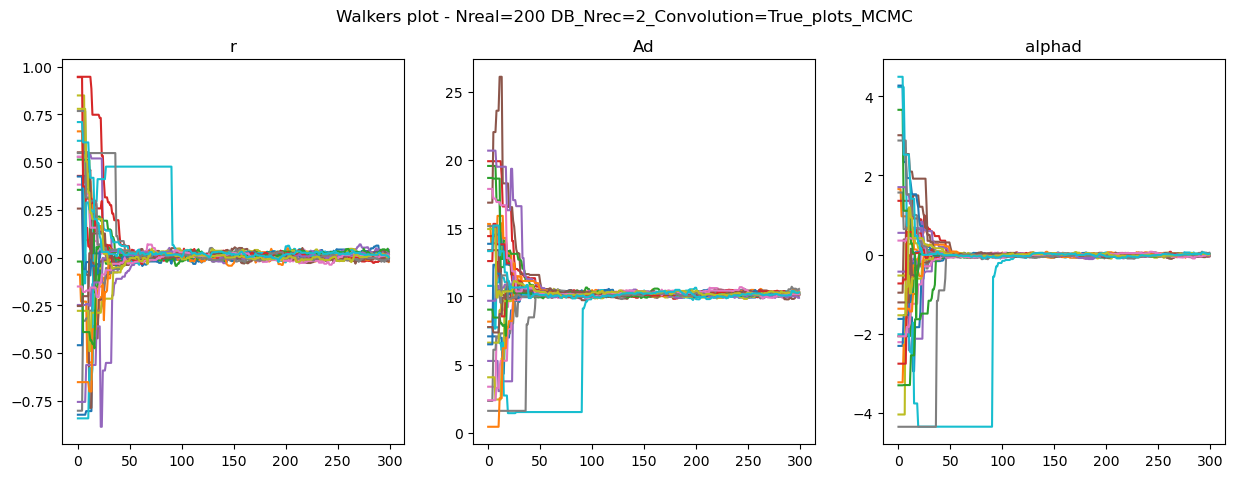

Removed no burn in


<Figure size 640x480 with 0 Axes>

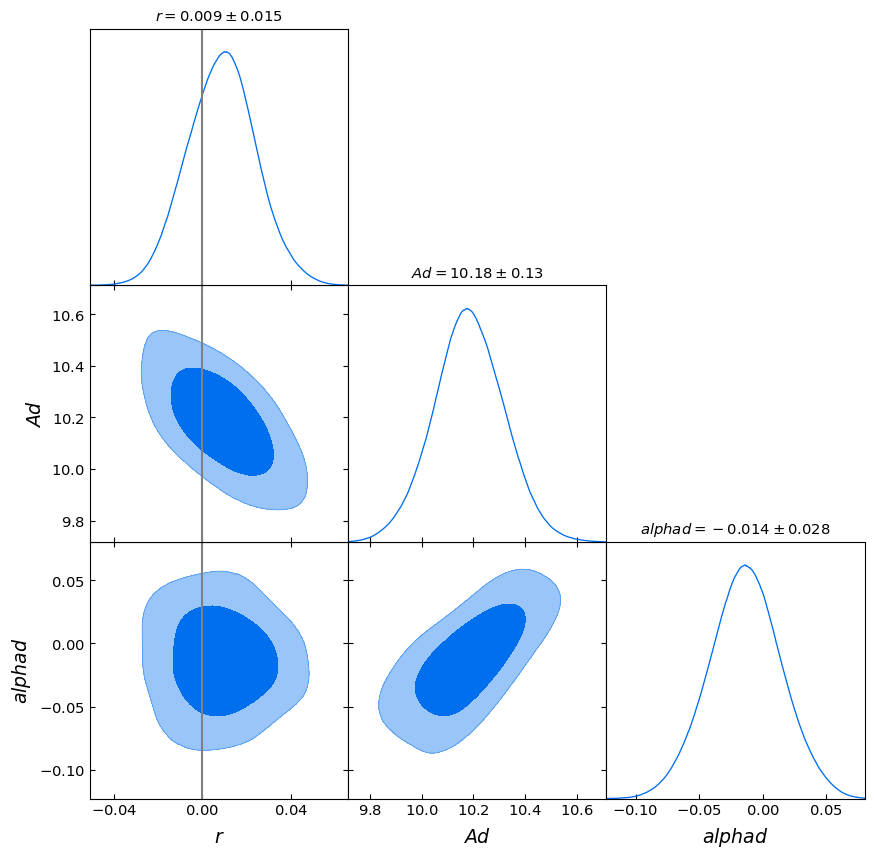

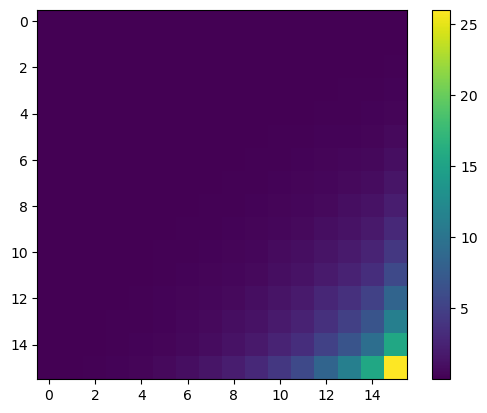

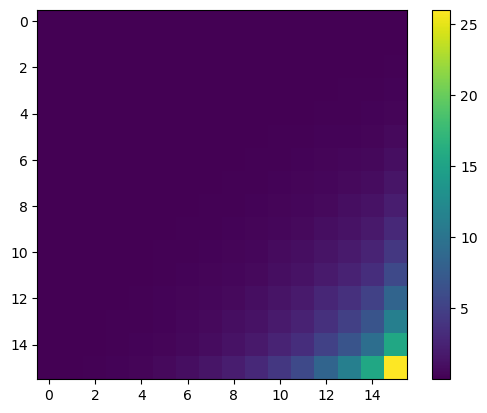

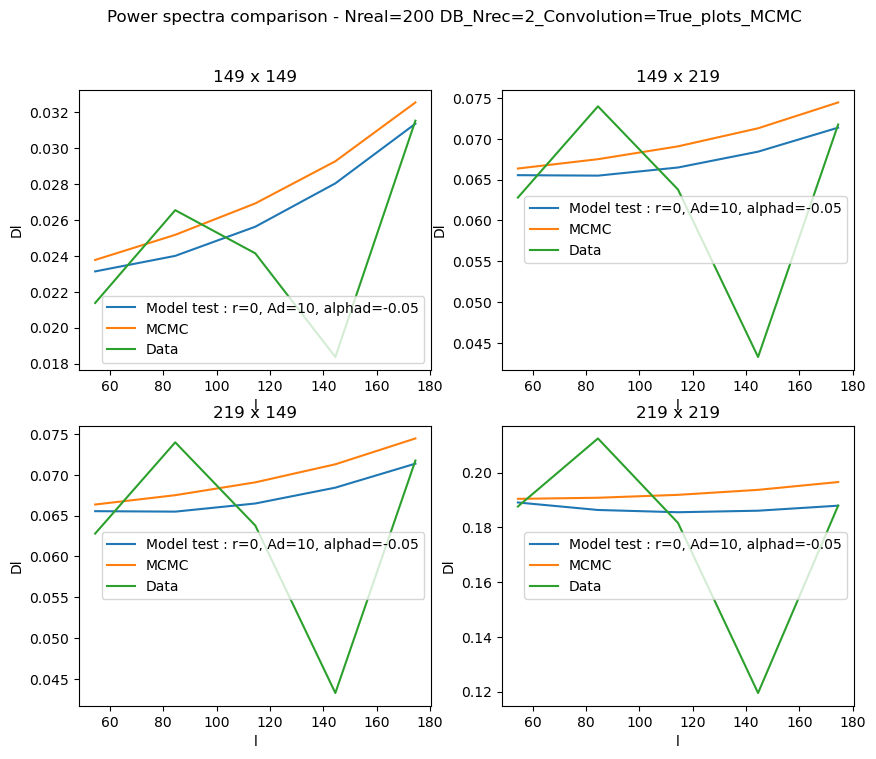

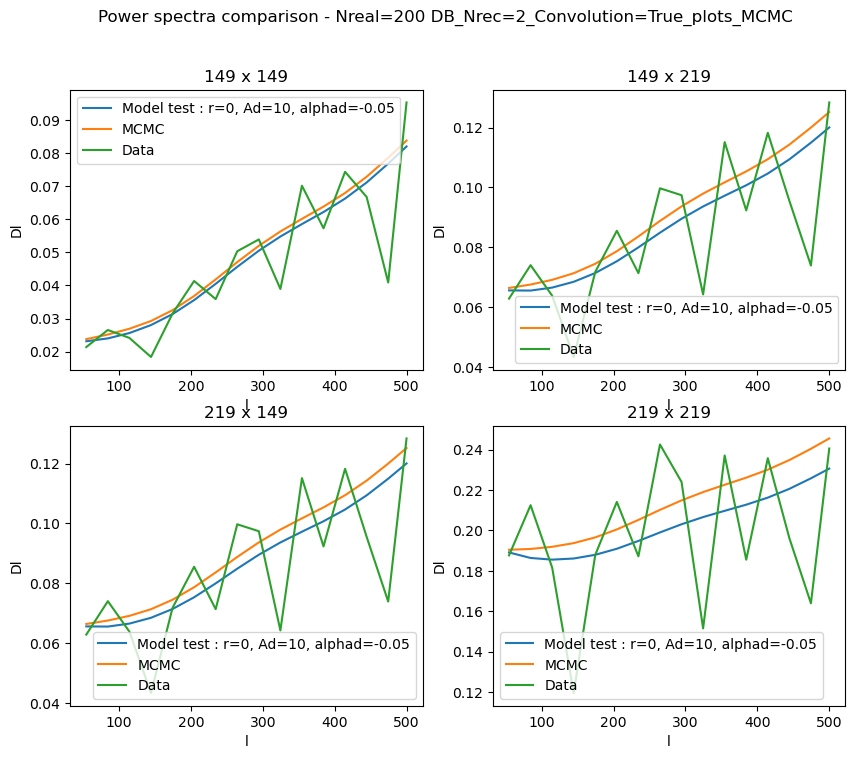

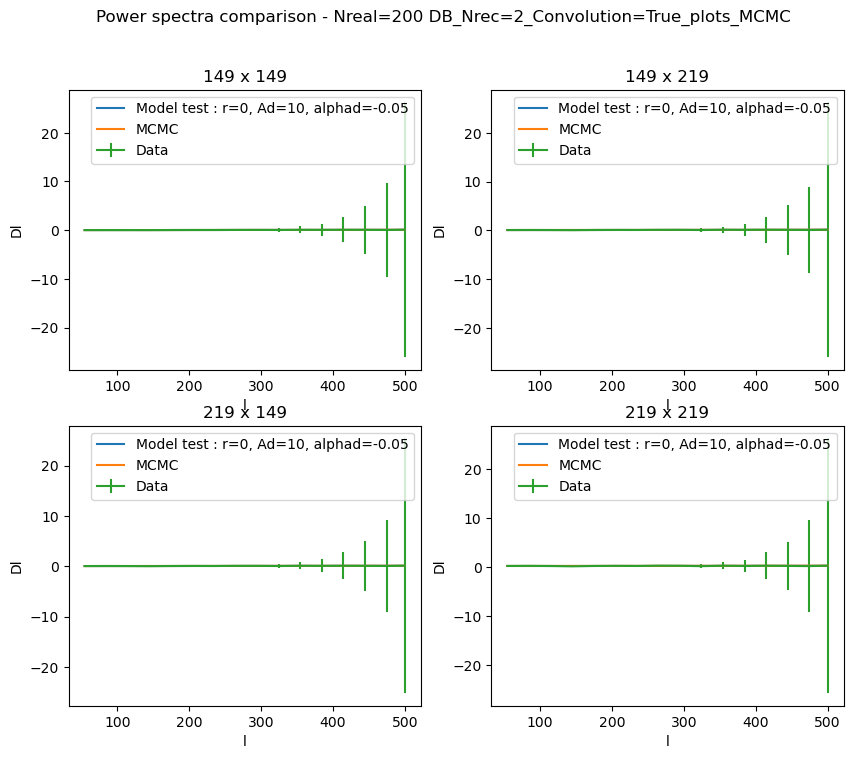

Fitting done


In [9]:
param = param_sampling
print('Sampling Parameters', param)

if param['Method'] == 'MCMC':
    print("Chosen method = MCMC")
    MCMC()()
elif param['Method'] == 'NS':
    print("Chosen method = Nested Sampling")
    NestedSampling()()
else:
    print('Wrong sampling method')

print("Fitting done")